In [1]:
%pylab inline
import time
import numpy as np
import cvxpy as cvx
import load.hcp_img_loader as hcp
import iterators.DmriPatchIterator as d
from scipy.sparse import csr_matrix
import experimento1_funciones as e1f
import load.samples as samples
import sys
import gc
import datetime
from utils import img_utils

#from threading import Thread, Lock
#from multiprocessing import Pool


#def uprint(*msg):
#    print msg
#    sys.stdout.flush()


Populating the interactive namespace from numpy and matplotlib


In [2]:
t1, t2, t3, t4 = ' '*4,' '*8, ' '*12, ' '*16


IS_NEF = '/home/lgomez/' in sys.prefix

if IS_NEF:
    from utils.persistence_array import parray
else:
    from utils.persistance.persistence_array import parray


def mm(A, cast_int=True):
    if cast_int:
        return (int(A.min()), int(A.max()))
    else:
        return (A.min(), A.max())


# ## MapMri

import mymapl.minmapl as mapl

# # 3D Tv-Norm
# $ \sum_{ijk \in positions(I)} \left|\left| (I_{i,j,k}, I_{i,j,k}, I_{i,j,k}) - ( I_{i-1,j,k}, I_{i,j-1,k},  I_{i,j,k-1}) \right|\right| $

import optimization.tvnorm3d as tvn


## Problem definition

FORMULA 1


$ \min_{C^{hr}} \{ \lambda  \left( \sum_{i}^{Nc} ||G_i C^{hr}_{i} - C^{lr}_{i}||^2 \right) + \beta ||C^{hr}UC^{hr^t}||^2 +\alpha ||C^{hr}||_{1} + \gamma ||MC^{hr}||_{TV}\}$
 


In [3]:

# In[5]:
def define_problem_f1(c_lr, vhr, vlr, G, M, U, tau, gtab, scale, intercept=None):
    Nx, Ny, Nz = (12, 12, 12)#TODO: pasar
    Nb, Nc = M.shape
    
    ## LR volumes
    Clr = c_lr
    
    ## MAPL params
    #cvxChr = cvx.Constant(C_hr.reshape(-1, order='F'))
    
    cvxChr = cvx.Variable(vhr*Nc, name='cvxChr')
    ChrValueInitial = np.ones((vhr*Nc, 1), dtype='float32')
    for c in xrange(Nc): 
        c_offset_hr = c*vhr
        ChrValueInitial[c_offset_hr:c_offset_hr+vhr] = ChrValueInitial[c_offset_hr:c_offset_hr+vhr]*Clr[c].mean()
    cvxChr.value = ChrValueInitial
    
    ## Fidelity expression
    cvxG = G
    fidelity_list = []
    lapace_list = []
    for c in xrange(Nc):
        c_offset_hr = c*vhr
        Chr_c = cvxChr[c_offset_hr:c_offset_hr+vhr]
        # Aprovecho para setearle un valor unicia
        Gc = cvx.Constant(G[c])
        Clr_c = cvx.Constant(Clr[c])
        #Clr_c = cvx.Variable(Clr[c].shape[0], Clr[c].shape[1], name='Clr_'+str(c))

        #       Gc:(216:vlr, 1728:vhr) Chr_c:(1728:vhr, 1) Clr_c:(1, 216:vlr)
        if intercept is not None:
            cvxInt_c = cvx.Constant(intercept[c])
            #cvxInt_c:(vlr, 1)
            fid_b = cvx.sum_squares((Gc * Chr_c + cvxInt_c) - Clr_c)
            #fid_b = cvx.sum_squares((Gc*Chr_c+cvxInt_c) - Clr_c.T)
        else:
            fid_b = cvx.sum_squares(Gc*Chr_c - Clr_c)
        
        fidelity_list.append(fid_b)    
    #cvxNc = cvx.Constant(Nc)
    #cvxFidelityExp = cvx.inv_pos(cvxNc)*sum(fidelity_list)
    cvxFidelityExp = sum(fidelity_list)
    
    ## Laplacian regularization
    cvxU = cvx.Constant(U)
    regLaplade_list = []
    vhrc = vhr*Nc
    for voxel in xrange(vhr):
        cvxLapaceReg = cvx.quad_form(cvxChr[voxel:vhrc:vhr], cvxU)
        regLaplade_list.append(cvxLapaceReg**2)
    cvxLaplaceRegExp = sum(regLaplade_list)
    
    
    ## 3D Tv-Norm Regularization
    cvxC_byCoef = cvx.reshape(cvxChr, vhr, Nc)
    # (Nb,Nc)*(Nc,vhr) = (Nb, vhr).T = (vhr, Nb) 
    cvxYhr = cvx.reshape((M*cvxC_byCoef.T).T, vhr*Nb, 1)
    #cvx3DTvNomExp = tvn.tv3d(cvxYhr, Nx, Ny, Nz, Nb)
    ## 3D Tv-Norm Regularization
    #cvx3DTvNomExp = tv3d(cvxYhr, Nx, Ny, Nz, Nb)

    
    #Sparcity regularization
    cvxNorm1 = cvx.norm1(cvxChr)
    
    
    
    ## Mapl weight
    beta = cvx.Parameter(value=1.452e-15, name='beta', sign='positive')#3.197e-10
    ## Sparcity weight
    alpha = cvx.Parameter(value=1.627e-15, name='alpha', sign='positive')#4.865e-10
    ## Tv-norm weight
    gamma = cvx.Parameter(value=1.627e-15, name='gamma',sign='positive')
    ## Fidelity weight
    lamda = cvx.Parameter(value=1., name='lamda',sign='positive')

    ### AS VARIABLES
    # beta = cvx.Variable(name='beta')
    # beta.value = 0.2
    ## Sparcity weight
    # alpha = cvx.Variable(name='alpha')
    # alpha.value = 4000
    ## Fidelity weight
    # gamma = cvx.Variable(name='gamma')
    # lamda = cvx.Variable(name='lamda')
    # lamda.value =0.5
    
    
    
    # Form objective.
    #obj = cvx.Minimize(cvxFidelityExp + beta*cvxLaplaceRegExp + alpha*cvxNorm1 + gamma*cvx3DTvNomExp)
    obj = cvx.Minimize(lamda*cvxFidelityExp + beta*cvxLaplaceRegExp + alpha*cvxNorm1)
         
    # Constraints
    #constraints = [lamda > 0 , alpha > 0, beta > 0]
    constraints = [cvxYhr >= 0]
    #Agregar q M*C es positivo o deberia

    # Form and solve problem.
    prob = cvx.Problem(obj, constraints)
    
    return prob, cvxFidelityExp ,  cvxLaplaceRegExp , cvxNorm1


FORMULA 2

$ \min_{Yhr, C^{hr}} \{ \lambda \left( \sum_{b}^{Nb} ||G_{b}Y^{hr}_{b} - Y^{lr}_{b}||^2 \right) + \beta ||C^{hr}UC^{hr^t}||^2 + \delta || Y^{hr} - MC^{hr} || + \alpha ||C^{hr}||_{1} + \gamma ||Y^{hr}||_{TV}\}$


In [4]:

def define_problem_f2(i_lr, i_hr_shape, G, M, U, tau, gtab, scale, intercept=None):
    Nb, Nc = M.shape
    Nx, Ny, Nz, bval = i_hr_shape
    vlr = Nx * Ny * Nz / (scale ** 3)
    vlrb = vlr * bval
    vhr = Nx * Ny * Nz
    vhrb = vhr * bval

    ## Hr volumes
    Yhr = cvx.Variable(vhrb, 1, name='cvxYhr')
    # Yhr.value = np.ones((vhrb, 1))*i_lr.mean()

    ## MAPL params
    # cvxChr = cvx.Constant(C_hr.reshape(-1, order='F'))
    cvxChr = cvx.Variable(vhr * Nc, name='cvxChr')
    # M:(Nb,Nc)
    cvxMaplE = (M * cvx.reshape(cvxChr, vhr, Nc).T).T
    # Hr image in row by b-val
    YhrMapl = cvx.reshape(Yhr, vhr, bval)
    # Mapl dual expression
    cvxMaplDualExp = cvx.sum_squares(cvxMaplE - YhrMapl)

    ## Laplacian regularization
    cvxU = cvx.Constant(U)
    regLaplade_list = []
    vhrc = vhr * Nc
    for voxel in xrange(vhr):
        cvxLapaceReg = cvx.quad_form(cvxChr[voxel:vhrc:vhr], cvxU)
        regLaplade_list.append(cvxLapaceReg ** 2)
    cvxLaplaceRegExp = sum(regLaplade_list)

    ## LA FORMA MATRICIAL NO ME DEJA DICE QUE NO SE PUEDE MULTIPLICAR DOS MATRICES
    #  cvxChr:(vhrc, 1) U:(Nc,Nc)
    # cvxC_byCoef = cvx.reshape(cvxChr, vhr, Nc)
    # cvxCUC = cvx.diag(cvxC_byCoef*cvxU*cvxC_byCoef.T)
    # cvxLapaceRegExp = cvx.sum_squares(cvxCUC)


    ## Fidelity expression
    # cvxG = G
    fidelity_list = []
    lapace_list = []
    for i in xrange(Nb):
        b = gtab.bvals[i]
        b_offset_hr = i * vhr
        Yhr_b = Yhr[b_offset_hr:b_offset_hr + vhr]
        # Aprovecho para setearle un valor unicia
        b_close = b
        if b not in G.keys():
            b_close = find_closest_b(b , G.keys())
            print t4, "WARNING: bval=", b , ' not in G dict-of-matrix use bval=', b_close, 'instead'
            sys.stdout.flush()

        Gb = cvx.Constant(G[b_close])

        # Sometimes the data set has E(q) for a same q , we need just one (so we take the average of al samples)
        if i_lr[b].shape[1] > 1 :
            #print '> Este set de datos tiene mas de una vez el b=', b, 'repeticiones=', len([z for z in gtab.bvals if z == b ])
            Ylr_b = cvx.Constant(i_lr[b].mean(axis=1))
        else:
            Ylr_b = cvx.Constant(i_lr[b])

        if intercept is not None:
            cvxInt_b = cvx.Constant(intercept[b_close])
            # cvxInt_c:(vlr, 1)
            fid_b = cvx.sum_squares((Gb * Yhr_b + cvxInt_b) - Ylr_b)
        else:
            fid_b = cvx.sum_squares(Gb * Yhr_b - Ylr_b)
        fidelity_list.append(fid_b)
    cvxFidelityExp = sum(fidelity_list)

    ## 3D Tv-Norm Regularization
    cvx3DTvNomExp = tvn.tv3d(Yhr, Nx, Ny, Nz, Nb)

    # Sparcity regularization
    cvxNorm1 = cvx.norm1(cvxChr)

    ## Mapl weight
    beta = cvx.Parameter(value=1.452e-15, name='beta', sign='positive')  # 3.197e-10
    ## Sparcity weight
    alpha = cvx.Parameter(value=1.627e-15, name='alpha', sign='positive')  # 4.865e-10
    ## Fidelity weight
    lamda = cvx.Parameter(value=1., name='lamda', sign='positive')
    ## 3D-Tv weight
    gamma = cvx.Parameter(value=2*1.627e-15, name='gamma', sign='positive')
    ### AS VARIABLES
    # beta = cvx.Variable(name='beta')
    # beta.value = 0.2
    ## Sparcity weight
    # alpha = cvx.Variable(name='alpha')
    # alpha.value = 4000
    ## Fidelity weight
    # gamma = cvx.Variable(name='gamma')
    # lamda = cvx.Variable(name='lamda')
    # lamda.value =0.5

    # Form objective.
    # obj = cvx.Minimize(cvxFidelityExp + betha*cvxLapaceRegExp + alpha*cvx.norm(cvxChr) + gamma*cvx3DTvNomExp)
    obj = cvx.Minimize(
        lamda * cvxFidelityExp + cvxMaplDualExp + beta * cvxLaplaceRegExp + alpha * cvxNorm1 + gamma * cvx3DTvNomExp)
    #obj = cvx.Minimize(
    #    lamda * cvxFidelityExp + cvxMaplDualExp + beta * cvxLaplaceRegExp + alpha * cvxNorm1)

    # Constraints
    # constraints = [lamda > 0 , alpha > 0, beta > 0]
    constraints = [Yhr >= 0]
    # Agregar q M*C es positivo o deberia

    # Form and solve problem.
    prob = cvx.Problem(obj, constraints)

    return prob, cvxFidelityExp, cvxLaplaceRegExp, cvxNorm1

def find_closest_b(b, list_of_bs):
    dif = np.abs(b-list_of_bs[0])
    closest = list_of_bs[0]
    for elem in list_of_bs :
        if np.abs(b-elem) < dif :
            dif = np.abs(b-elem)
            closest = elem
    return closest


In [5]:

def try_value(i_hr,M, Nx, Ny, Nz, Nb, Nc, b1000_index, b2000_index, b3000_index,\
              definition_fun, max_iters, verbose, i=-1, res=None):
    prob = None
    prob, cvxFidelityExp,  cvxLaplaceRegExp, cvxNorm1 = definition_fun()

    #parameters = dict( (v.name(), v) for v in prob.parameters())
    
    print t3, "--- About start first round:", datetime.datetime.now()
    verbose=False
    start_time = time.time()
    prob.solve(solver='SCS', max_iters=200, eps=1.0e-05, verbose=verbose)  # Returns the optimal value.
    print t3, "--- status:", prob.status, "optimal value", prob.value, datetime.datetime.now()
    sys.stdout.flush()
    pval_ant = prob.value
    prob.solve(solver='SCS', max_iters=200, eps=1.0e-05, verbose=verbose)  # Returns the optimal value.
    print t3, "--- status:", prob.status, "optimal value", prob.value, np.abs(pval_ant-prob.value), datetime.datetime.now()
    sys.stdout.flush()
    pval_ant = prob.value
    prob.solve(solver='SCS', max_iters=200, eps=1.0e-05, verbose=verbose)  # Returns the optimal value.
    print t3, "--- status:", prob.status, "optimal value", prob.value, np.abs(pval_ant-prob.value), datetime.datetime.now()
    sys.stdout.flush()
    pval_ant = prob.value
    prob.solve(solver='SCS', max_iters=200, eps=1.0e-05, verbose=verbose)  # Returns the optimal value.
    seg = time.time() - start_time
    minutes = int(seg / 60)
    print t3, "--- time of optimization : %d' %d'' (subject:%s) ---" % (minutes , seg%60, subject)
    print t3, "--- status:", prob.status, "optimal value", prob.value ,np.abs(pval_ant-prob.value),  datetime.datetime.now()
    #sys.stdout.flush()

    # Get result
    variables = dict( (v.name(), v) for v in prob.variables())

    cvxChr = variables['cvxChr']
    C = np.asarray(cvxChr.value, dtype='float32').reshape((Nx, Ny, Nz, Nc), order='F')

    if 'cvxYhr' in variables :
        cvxYhr = variables['cvxYhr']
        A = np.asarray(cvxYhr.value, dtype='float32').reshape((Nx, Ny, Nz, Nb), order='F')
    else:
        A = M.dot(C.reshape((Nx*Ny*Nz, Nc), order='F').T).T
        A = A.reshape((Nx, Ny, Nz, Nb), order='F')

    mse = ((A-i_hr)**2).mean()
    #info['mse'].append(mse)
    print t3, 'mse=', mse

    mse1000 = ((A[:, :, :, b1000_index]-i_hr[:, :, :, b1000_index])**2).mean()
    #info['mse1000'].append(mse1000)
    print t3, A[:, :, :, b1000_index].shape, i_hr[:, :, :, b1000_index].shape, 'mse1000=', mse1000
    #sys.stdout.flush()

    mse2000 = ((A[:, :, :, b2000_index]-i_hr[:, :, :, b2000_index])**2).mean()
    #info['mse2000'].append(mse2000)

    mse3000 = ((A[:, :, :, b3000_index]-i_hr[:, :, :, b3000_index])**2).mean()
    #info['mse3000'].append(mse3000)

    if cvxFidelityExp is not None:
        print t3, 'cvxFidelityExp', cvxFidelityExp.value

    if cvxLaplaceRegExp is not None:
        print t3, 'cvxLaplaceRegExp', cvxLaplaceRegExp.value

    if cvxNorm1 is not None:
        print t3, 'cvxNorm1', cvxNorm1.value , datetime.datetime.now()

    #del (A, C, prob, cvxFidelityExp, cvxLaplaceRegExp, cvxNorm1)
    
    print t3, '.', datetime.datetime.now()
    #sys.stdout.flush()
    print t3, '.', datetime.datetime.now()
    print t3, '.'

    if res is not None:
        res[i] = (mse, mse1000, mse2000, mse3000, seg)
    
    return A, C, mse, mse1000, mse2000, mse3000, seg


In [6]:
def solveMin_fitCosnt(subject,i,j,k, loader_func, G, intercept=None, scale=2, max_iters=1500, verbose=False, prob=None):

    definition_fun = None
    if FORMULA == FORMULA_NO1 :
        # Get input for the subject to fit
        _, c_lr, gtab, i_hr, i_lr = samples.get_sample_of_mapl(subject,i,j,k, loader_func, scale=scale)
        c_lr = samples.split_by(c_lr)
        # Mapl params
        M, tau, mu, U = mapl.get_mapl_params2(gtab, radial_order=4)

        definition_fun = lambda : define_problem_f1(
                                    c_lr,
                                    vhr,
                                    vlr,
                                    G,
                                    M, U,tau,
                                    gtab,
                                    scale,
                                    intercept=intercept)
    else:
        # Get input for the subject to fit
        i_hr, i_lr, gtab = samples.get_sample_of_dwi(subject, i,j,k,loader_func, bsize=BSIZE, scale=scale)
        #print t2, 'i_hr:', i_hr.shape, 'i_lr:', i_lr.shape
        i_lr = samples.split_by_bval(i_lr, gtab)
        # Mapl params
        M, tau, mu, U = mapl.get_mapl_params2(gtab, radial_order=4)

        definition_fun = lambda : define_problem_f2(i_lr, i_hr.shape, G, M, U, tau, gtab, scale, intercept=intercept)
    
    #sys.stdout.flush()

    Nx, Ny, Nz, Nb = i_hr.shape
    Nb, Nc = M.shape
    nx, ny, nz = Nx / scale, Ny / scale, Nz / scale
    vhr, vlr = Nx * Ny * Nz, nx * ny * nz

    cvxFidelityExp, cvxLaplaceRegExp, cvxNorm1 = None, None, None

    b1000_index = indexs(gtab.bvals, 1000)
    b2000_index = indexs(gtab.bvals, 2000)
    b3000_index = indexs(gtab.bvals, 3000)

    measures = ['mse', 'mse1000', 'mse2000', 'mse3000']
    #info = dict((key, parray(base_folder + key + '_' + str(subject) + '.txt')) for key in measures)
    info = dict((key, []) for key in measures)
    segs = 0

    """ Sequencial"""
    A, C, mse, mse1000, mse2000, mse3000, seg = try_value(i_hr,M, Nx, Ny, Nz, Nb, Nc, b1000_index, b2000_index, b3000_index, \
                    definition_fun, max_iters, verbose)
    
    info['mse'].append(mse)
    info['mse1000'].append(mse1000)
    info['mse2000'].append(mse2000)
    info['mse3000'].append(mse3000)
    segs += seg

    print t3, 'fin fit al values for subject:', subject, 'segs:', seg,  datetime.datetime.now()
    # return A, C, seg, prob, cvxFidelityExp, cvxLaplaceRegExp , cvxNorm1, info
    return A, C, segs, None, None, None, None, info


def indexs(a, val):
    return [ i for i in xrange(a.size) if a[i] == val]

# In[8]:
def params_for(subjects, i, j, k, sample_maker, bvals_needed=None, scale=2):
    ## The one that left out to validate

    if FORMULA == FORMULA_NO2:
        lr_samples, hr_samples = samples.buildT_grouping_by(subjects, i, j, k, sample_maker, use_bvals=True, scale=scale) #lr, hr
    else:
        lr_samples, hr_samples = samples.buildT_grouping_by(subjects, i, j, k, sample_maker, scale=scale)  # lr, hr

    # Build downsampling matrix
    print '= Training and fiting n_samples: %d ...' % len(subjects), datetime.datetime.now()
    
    regr, _ , _, intercept = e1f.train_grouping_by(hr_samples, lr_samples, intercept=False)

    G = dict((c,csr_matrix(regr[c].coef_)) for c in regr.keys())

    del(lr_samples)
    del(hr_samples)
    #gc.collect()

    return G, intercept
    


In [7]:
from conf_exp6 import *

# ## Solving the problem and cross-validation (leave one out)

#formula_to_use = sys.argv[2]
formula_to_use = 'f1'
FORMULA = formulas[formula_to_use]

#bvals2000pos = [18, 27, 69, 75, 101, 107]

## Con imagenes pequenas multi-shel
SCALE=2
loader_func = hcp.load_subject_medium_noS0

if FORMULA == FORMULA_NO2:
    sample_maker = samples.get_sample_maker_of_dwi(loader_func, bsize=BSIZE)
else:
    sample_maker = samples.get_sample_maker_of_map(loader_func, bsize=BSIZE)

n_samples = len(subjects)

#param_name = sys.argv[1]
#param_name = 'lamda'

#name_parameter = param_name
#rango = params_range[param_name]

base_folder = RES_BASE_FOLDER + formula_to_use + '/scale/'

# Metrics to save

mins_lamda   = []
times        = []

#group_number_job = int(sys.argv[3])
group_number_job = 0

#fit_index_job = int(sys.argv[4])%FITS
fit_index_job = 0


scales = [4, 3, 2, 1.5, 1.2]
scales = scales[3:4]

print 'STARTING JOB FOR scale USING FORMULA', FORMULA , ' GROUP-job:', group_number_job, 'FIT-index', fit_index_job,   datetime.datetime.now()
print 'WITH RANGE:', scales,
sys.stdout.flush()


GROUPS = n_samples/GROUP_SIZE
RANGO= len(scales)

"""
mse = np.zeros((RANGO, FITS, GROUPS), dtype='float32')
mse1000 = np.zeros((RANGO, FITS, GROUPS), dtype='float32')
mse2000 = np.zeros((RANGO, FITS, GROUPS), dtype='float32')
mse3000 = np.zeros((RANGO, FITS, GROUPS), dtype='float32')
"""
mse = np.zeros((RANGO), dtype='float32')
mse1000 = np.zeros((RANGO), dtype='float32')
mse2000 = np.zeros((RANGO), dtype='float32')
mse3000 = np.zeros((RANGO), dtype='float32')


#subjects = subjects[GROUP_SIZE:] + subjects[:GROUP_SIZE]



scales

STARTING JOB FOR scale USING FORMULA Formula1  GROUP-job: 0 FIT-index 0 2016-09-14 17:20:30.602714
WITH RANGE: [1.5]

[1.5]

In [8]:
it = d.DmriPatchIterator(range(8, 12, 12), range(7, 14, 14), range(8, 12, 12))
for i, j, k in it:
    for group_num in [group_number_job]:
        for si in xrange(len(scales)):
            scale = scales[si]

            subject_offset = GROUP_SIZE*group_number_job
            train_subjects = subjects[subject_offset:subject_offset+GROUP_SIZE]
            test_set = subjects[:subject_offset] + subjects[subject_offset+GROUP_SIZE:]
            test_set = test_set[:FITS]
            print 'len(test)', len(test_set), 'len(group)', len(train_subjects)

            # Linear regresion of this group
            print
            print datetime.datetime.now()
            train_time = time.time()
            G, intercept = params_for(train_subjects, i, j, k, sample_maker, scale=scale)
            train_time = time.time() - train_time
            print "== Training of Group:%d    (%d'%d'')"%(group_num, int(train_time/60), int(train_time%60)), datetime.datetime.now()

            sys.stdout.flush()

            for subject_index in [fit_index_job]:
                subject = test_set[subject_index]
                print '/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/'
                print t1, '== Group:%d of %d Fiting subject:%d(%d,%d,%d) of %d (%d)#' % (group_num, GROUPS, subject_index,i,j,k, FITS,  subject), datetime.datetime.now()
                print t1, '= Solving optimization problem (subject: %s, param: %s) === ' % (subject, 'scale'), datetime.datetime.now()
                sys.stdout.flush()

                A, C, seg, prob, cvxFidelityExp, cvxLaplaceRegExp, cvxNorm1, res =\
                    solveMin_fitCosnt(subject,
                                      i, j, k,
                                      loader_func,
                                      G,
                                      intercept=intercept,
                                      scale=scale,
                                      max_iters=MAX_ITERS,
                                      verbose=False)

                # Saving all results for analize latter
                mse[si] = res['mse'][0]
                mse1000[si] = res['mse1000'][0]
                mse2000[si] = res['mse2000'][0]
                mse3000[si] = res['mse3000'][0]

                ## Para guardar info si se quiere
                #for key in res.keys():
                #    p = parray(base_folder + key + '_' + str(subject) + '.txt')
                #    p = p+res[key]

                times.append(seg)
                #optimal_vals.append(prob.value)

                #if A is not None:
                #    del(prob, A, C, cvxFidelityExp, cvxLaplaceRegExp, cvxNorm1)
                del(res)
                del(seg)
                print 'len(gc.garbage[:])', len(gc.garbage[:]),'number of unreachable objects found:', gc.collect()

            del(G, intercept)
            #gc.collect()


len(test) 1 len(group) 5

2016-09-14 17:20:30.693107
.Apunto de cargar bvals 100307
.Apunto de cargar bvecs 100307
Apunto de cargar patch  100307
LOADING ./HCP/100307/data_medium40g_12x12x12x40_100307.nii.gz
scale= 1.5 lr.shape= (8, 8, 8, 40)


/user/lgomez/home/anaconda2/lib/python2.7/site-packages/scipy/ndimage/interpolation.py:430: UserWarning: The behaviour of affine_transform with a one-dimensional array supplied for the matrix parameter has changed in scipy 0.18.0.
  "The behaviour of affine_transform with a one-dimensional "


.Apunto de cargar bvals 100307
.Apunto de cargar bvecs 100307
Apunto de cargar patch  100307
LOADING ./HCP/100307/data_medium40g_12x12x12x40_100307.nii.gz
scale= 1.5 lr.shape= (8, 8, 8, 40)
.Apunto de cargar bvals 100307
.Apunto de cargar bvecs 100307
Apunto de cargar patch  100307
LOADING ./HCP/100307/data_medium40g_12x12x12x40_100307.nii.gz
scale= 1.5 lr.shape= (8, 8, 8, 40)
.Apunto de cargar bvals 100307
.Apunto de cargar bvecs 100307
Apunto de cargar patch  100307
LOADING ./HCP/100307/data_medium40g_12x12x12x40_100307.nii.gz
scale= 1.5 lr.shape= (8, 8, 8, 40)
.Apunto de cargar bvals 100307
.Apunto de cargar bvecs 100307
Apunto de cargar patch  100307
LOADING ./HCP/100307/data_medium40g_12x12x12x40_100307.nii.gz
scale= 1.5 lr.shape= (8, 8, 8, 40)
= Training and fiting n_samples: 5 ... 2016-09-14 17:20:39.119370
== Training of Group:0    (0'9'') 2016-09-14 17:20:40.380410
/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/
   

/user/lgomez/home/anaconda2/lib/python2.7/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/user/lgomez/home/anaconda2/lib/python2.7/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


 137.276564043
             cvxLaplaceRegExp 32323.4531974
             cvxNorm1 4265.55414672 2016-09-14 17:28:05.118790
             . 2016-09-14 17:28:05.118846
             . 2016-09-14 17:28:05.118886
             .
             fin fit al values for subject: 180937 segs: 433.833536863 2016-09-14 17:28:05.134971
len(gc.garbage[:]) 0 number of unreachable objects found: 189563


.Apunto de cargar bvals 100307
.Apunto de cargar bvecs 100307
Apunto de cargar patch  100307
LOADING ./HCP/100307/data_medium40g_12x12x12x40_100307.nii.gz
scale= 2 lr.shape= (6, 6, 6, 40)
(12, 12, 12, 37) (12, 12, 12, 37) (6, 6, 6, 37) (0, 1) (0, 3)


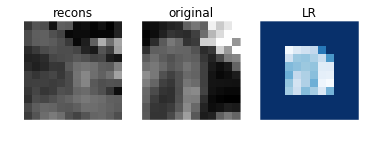

990.0

In [9]:
it = d.DmriPatchIterator(range(8, 12, 12), range(7, 14, 14), range(8, 12, 12))
i,j,k =it.next()

i_hr, i_lr, gtab = samples.get_sample_of_dwi(100307, i,j,k,loader_func, bsize=BSIZE, scale=scale)
        
print A.shape, i_hr.shape, i_lr.shape, mm(A), mm(i_hr)

Nx, Ny, Nz, _ = i_hr.shape
nx, ny, nz, _ = i_lr.shape

mx, my, mz = (Nx-nx)/2 , (Ny-ny)/2, (Nz-nz)/2

I_lr = np.ones(i_hr.shape)


for b in xrange(I_lr.shape[3]):
    I_lr[mx:mx+nx,my:my+ny,mz:mz+nz,b] = i_lr[:, :, :, b]

b=6
plt, _, _, im3 = img_utils._isc3(A, i_hr, I_lr, b=b, vmax=1, titles=['recons', 'original', 'LR'])
plt.set_cmap('gray')
gtab.bvals[b]


# f2 con gamma=5.6e-15 con intercep

.Apunto de cargar bvals 100307
.Apunto de cargar bvecs 100307
Apunto de cargar patch  100307
LOADING ./HCP/100307/data_medium40g_12x12x12x40_100307.nii.gz
scale= 1.5 lr.shape= (8, 8, 8, 40)
(12, 12, 12, 37) (12, 12, 12, 37) (8, 8, 8, 37) (0, 1) (0, 3)


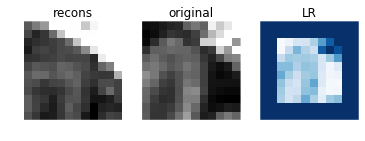

990.0

In [9]:
it = d.DmriPatchIterator(range(8, 12, 12), range(7, 14, 14), range(8, 12, 12))
i,j,k =it.next()

i_hr, i_lr, gtab = samples.get_sample_of_dwi(100307, i,j,k,loader_func, bsize=BSIZE, scale=scale)
        
print A.shape, i_hr.shape, i_lr.shape, mm(A), mm(i_hr)

Nx, Ny, Nz, _ = i_hr.shape
nx, ny, nz, _ = i_lr.shape

mx, my, mz = (Nx-nx)/2 , (Ny-ny)/2, (Nz-nz)/2

I_lr = np.ones(i_hr.shape)


for b in xrange(I_lr.shape[3]):
    I_lr[mx:mx+nx,my:my+ny,mz:mz+nz,b] = i_lr[:, :, :, b]

b=6
plt, _, _, im3 = img_utils._isc3(A, i_hr, I_lr, b=b, vmax=1, titles=['recons', 'original', 'LR'])
plt.set_cmap('gray')
gtab.bvals[b]


# f1 sin gamma mas pequenio sin intercep con scale=1.5

In [40]:
reload(img_utils)

<module 'utils.img_utils' from 'utils/img_utils.py'>

In [ ]:

index = np.argmin(np.array(mse))
min_lamda = scales[index]
mins_lamda.append(min_lamda)

print 'Ultimos calculos', datetime.datetime.now()
sys.stdout.flush()

# Persist min vals
pmins_lamda   = parray(base_folder + 'mins_mses.txt', mins_lamda)
ptimes        = parray(base_folder +'times.txt',times)
#poptimal_vals = parray(base_folder +'optimal_vals.txt', optimal_vals)

# Log spended time
total_sec = np.array(times).sum()
print ' === TOTAL TIME :',  str(int(total_sec//60))+"'", str(int(total_sec%60))+ '"' , datetime.datetime.now()
sys.stdout.flush()

# Persist results
#if base_folder is not None: 
#    np.save(base_folder+ 'mins_alphas', mins_lamda)


name = '%d_%d_%d' % (RANGO, FITS, GROUPS)
base_name = base_folder + 'mse_g'+ str(group_number_job) +'_f'+str(fit_index_job) + '_' + name
np.save(base_name, mse)
print 'saved:', base_name
base_name = base_folder + 'mse%d_g'+ str(group_number_job) +'_f'+str(fit_index_job) + '_' + name
np.save(base_name%(1000), mse1000)
print 'saved:', base_name%(1000)
np.save(base_name%(2000), mse2000)
print 'saved:', base_name%(2000)
np.save(base_name%(3000), mse3000)
print 'saved:', base_name%(3000)


mins_lamda = np.array(mins_lamda)
print 'Subjects fitted = ', mins_lamda.shape
print 'mean=', mins_lamda.mean(),  mins_lamda
#plt.bar(xrange(mins_lamda.size), mins_lamda)
#plt.savefig(base_folder + '/mins_' + param_name + '.pdf')

# In[11]:
print 'rangos:', scales
print 'mins_%s:' % ('scale') , mins_lamda

#dict((v.name(), v.value) for v in prob.variables())
print 'Lito!', datetime.datetime.now()
sys.stdout.flush()